# Installation and Imports

In [83]:
# Check the GPU
!nvidia-smi

Wed Jul 15 22:56:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    60W / 149W |   8423MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [84]:
import warnings
warnings.simplefilter("ignore", UserWarning)
# warnings.filterwarnings('ignore')

import os.path

from keras import Model, optimizers
from keras.applications import xception
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

## Configuration Parameters

In [85]:
img_width = 197
img_height = 197

batch_size = 128

base_path = '/content/drive/My Drive/Colab_Notebooks/data/monkey/'

train_path = base_path + 'training-data/training'
validation_path = base_path + 'validation-data/validation'

nb_classes = 10

## Preparing the dataset

In [86]:
# Counts the number of training and testing samples in the directories
training_samples = sum([len(files) for r, d, files in os.walk(train_path)])
validation_samples = sum([len(files) for r, d, files in os.walk(validation_path)])

print("Number of samples in Training dataset:", training_samples)
print("Number of samples in Validation dataset:", validation_samples)

Number of samples in Training dataset: 1098
Number of samples in Validation dataset: 272


## Data augmentation

In [87]:
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.3,
    height_shift_range = 0.2,
    rescale = 1.0 / 255,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
    vertical_flip = False,
)

validation_datagen = ImageDataGenerator(rescale = 1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


# Model

## Importing the pre-trained model

In [88]:
# Import the Xception model to use as the base for our model
xception_base = xception.Xception(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_width, img_height, 3)
)

In [89]:
xception_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 98, 98, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 98, 98, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 98, 98, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## Transfer learning

In [90]:
# Adds new top to base model
def add_top(base):
    x = base.output

    # Global averaging pool layer
    x = GlobalAveragePooling2D()(x)

    # Regular densely connected layer
    x = Dense(512, activation='relu')(x)

    # Output layer
    predictions = Dense(nb_classes, activation='softmax')(x)

    return Model(inputs = base.input, outputs = predictions)

In [91]:
# Sets up model for transfer learning
def setup_model(model, base):
    # Freeze the un-trainable layers of the model base
    for layer in base.layers:
        layer.trainable = False

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'rmsprop',
        metrics = ['accuracy']
    )

In [92]:
# Fine tune the model
def fine_tune(model, trainable):
    # Freeze the un-trainable layers of the model base
    for layer in model.layers[:(len(model.layers) - trainable)]:
        layer.trainable = False

    for layer in model.layers[(len(model.layers) - trainable):]:
        layer.trainable = True

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizers.SGD(lr = 1e-4, momentum = 0.9),
        metrics = ['accuracy']
    )

In [93]:
# appending our trainable layers to the end of the model
model = add_top(xception_base)

## Training

We are using a hybrid approach, at first we train with RMSprop/Adam until we get a better initial state for SGD optimizer, then we start the training again with SGD.

Training the layers we added while freezing all the original model layers.

In [94]:
# setup the model
setup_model(model, xception_base)

In [95]:
epochs = 20

# train the model
history1 = model.fit_generator(
    train_generator,
    steps_per_epoch = training_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_samples // batch_size,
    verbose = 1,
)

Epoch 1/20
8/8 [==============================] - 45s 6s/step - loss: 2.1048 - accuracy: 0.3485 - val_loss: 0.9759 - val_accuracy: 0.7188
Epoch 2/20
8/8 [==============================] - 39s 5s/step - loss: 1.0913 - accuracy: 0.6845 - val_loss: 0.7690 - val_accuracy: 0.8264
Epoch 3/20
8/8 [==============================] - 35s 4s/step - loss: 0.8359 - accuracy: 0.7617 - val_loss: 0.3871 - val_accuracy: 0.9097
Epoch 4/20
8/8 [==============================] - 40s 5s/step - loss: 0.7398 - accuracy: 0.7887 - val_loss: 0.5695 - val_accuracy: 0.8281
Epoch 5/20
8/8 [==============================] - 40s 5s/step - loss: 0.5808 - accuracy: 0.8289 - val_loss: 0.5301 - val_accuracy: 0.8889
Epoch 6/20
8/8 [==============================] - 34s 4s/step - loss: 0.6306 - accuracy: 0.7979 - val_loss: 0.3416 - val_accuracy: 0.9028
Epoch 7/20
8/8 [==============================] - 36s 5s/step - loss: 0.4996 - accuracy: 0.8450 - val_loss: 0.4832 - val_accuracy: 0.8984
Epoch 8/20
8/8 [==================

## Fine-tuning

Re-train the model again using the weights we got from the first training for our new added layers, and in the same time we will un-freeze the last two layers of the original model.

In [96]:
# fine tune the model to retrain our top layer plus blocks 13 and 14 of Xception
fine_tune(model, 19)

In [97]:
epochs_ft = 20

# train the model
history2 = model.fit_generator(
    train_generator,
    steps_per_epoch = training_samples // batch_size,
    epochs = epochs_ft,
    validation_data = validation_generator,
    validation_steps = validation_samples // batch_size,
    verbose = 1,
)

Epoch 1/20
8/8 [==============================] - 47s 6s/step - loss: 0.3895 - accuracy: 0.8794 - val_loss: 1.0593 - val_accuracy: 0.8867
Epoch 2/20
8/8 [==============================] - 36s 4s/step - loss: 0.3480 - accuracy: 0.8887 - val_loss: 1.0364 - val_accuracy: 0.8750
Epoch 3/20
8/8 [==============================] - 36s 5s/step - loss: 0.3502 - accuracy: 0.8887 - val_loss: 1.2126 - val_accuracy: 0.9375
Epoch 4/20
8/8 [==============================] - 42s 5s/step - loss: 0.3403 - accuracy: 0.8936 - val_loss: 0.6755 - val_accuracy: 0.9141
Epoch 5/20
8/8 [==============================] - 39s 5s/step - loss: 0.3132 - accuracy: 0.8919 - val_loss: 0.6356 - val_accuracy: 0.9167
Epoch 6/20
8/8 [==============================] - 32s 4s/step - loss: 0.3054 - accuracy: 0.9041 - val_loss: 1.4064 - val_accuracy: 0.8889
Epoch 7/20
8/8 [==============================] - 43s 5s/step - loss: 0.2984 - accuracy: 0.9072 - val_loss: 1.1421 - val_accuracy: 0.9180
Epoch 8/20
8/8 [==================

# Diagrams

## Model Diagrams

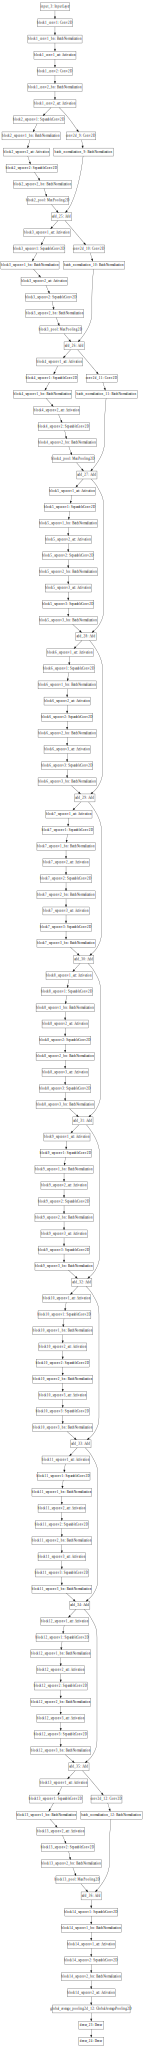

In [98]:
SVG(model_to_dot(model, show_shapes = False, show_layer_names=True, rankdir='HB', dpi = 72).create(prog='dot', format='svg'))

In [99]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 98, 98, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 98, 98, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 98, 98, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## Learning Curves

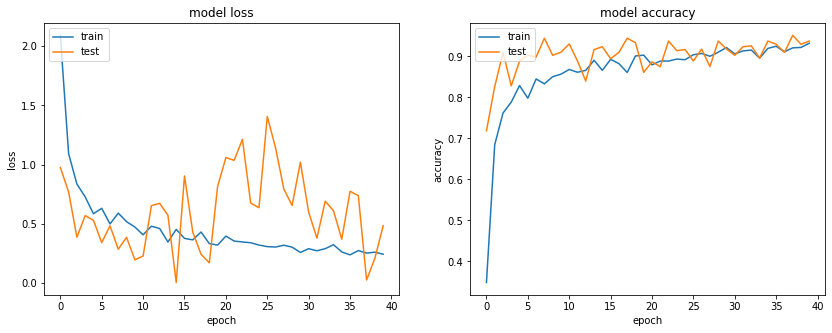

In [100]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

loss = history1.history["loss"] + history2.history["loss"]
val_loss = history1.history["val_loss"] + history2.history["val_loss"]
accuracy = history1.history["accuracy"] + history2.history["accuracy"]
val_accuracy = history1.history["val_accuracy"] + history2.history["val_accuracy"]

ax[0].plot(loss)
ax[0].plot(val_loss)
ax[0].set_title("model loss")
ax[0].set_ylabel("loss")
ax[0].set_xlabel("epoch")
ax[0].legend(["train", "test"], loc="upper left")

ax[1].plot(accuracy)
ax[1].plot(val_accuracy)
ax[1].set_title("model accuracy")
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel("epoch")
ax[1].legend(["train", "test"], loc="upper left")

plt.show()

The momentum is big, that is why there is some overshooting in the model loss graph for the SGD part, also SGD tind to do these spikes because of the mini batches usage. For the first part, it is because we are doing a transfer learning.

If we had like 3000 epochs, our graph will smooth over and spikes won't be that noticable.

From the graph, we can see that more epochs will help in getting more accuracy, our model doesn't overfit, and there is no underfit.

# References
* https://colab.research.google.com/github/nipunbatra/blog/blob/master/_notebooks/2017-12-29-neural-collaborative-filtering.ipynb#scrollTo=t23DgPbMQFng
* https://www.kaggle.com/slothkong/10-monkey-species?select=monkey_labels.txt
* https://keras.io/api/applications/
* https://www.kaggle.com/voandy/transfer-learning-fine-tuning-xception-98-7-acc
* https://github.com/zaid478/Transfer-Learning-from-Xception-Model-in-Keras-/blob/master/transfer_learn.py
* https://medium.com/@vigneshgig/xception-neural-network-transfer-learning-and-data-processing-using-ai-c3e7a4ea7bf2
* https://www.kaggle.com/abnera/transfer-learning-keras-xception-cnn
* https://arxiv.org/abs/1610.02357
* https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568
* https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
* https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c
* https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
* https://keras.io/guides/transfer_learning/
* https://stats.stackexchange.com/questions/303857/explanation-of-spikes-in-training-loss-vs-iterations-with-adam-optimizer

